In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from helper import *

Now let's start by running gradient descent with different learning rate and steps, purpose is to observe how the learning rate affects the convergence of the algorithm.

**Get Loss Function for Plotting**:
    We are calling the `get_loss_function_for_plot` function to obtain the loss function and the mesh grids (`x1mesh` and `x2mesh`) for plotting.

**Initialize Starting Position**:
    This block initializes the starting position for the gradient descent algorithm.

**Run Gradient Descent with Small Learning Rate**:
    This block runs the gradient descent algorithm with a learning rate (`alpha`). The `grad_descent` function returns the path taken by the gradient descent, which is then plotted using the `draw_function`.

**Run Gradient Descent with Large Learning Rate**:
    This block runs the gradient descent algorithm again, but this time with a larger learning rate (`alpha`). The resulting path is also plotted using the `draw_function`.


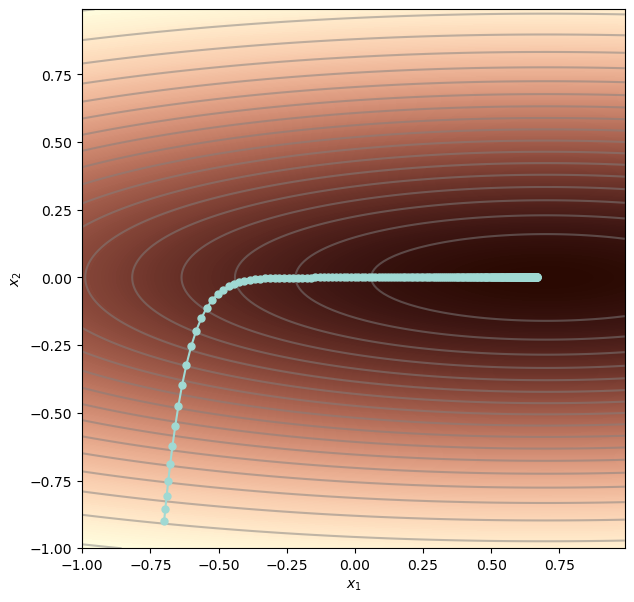

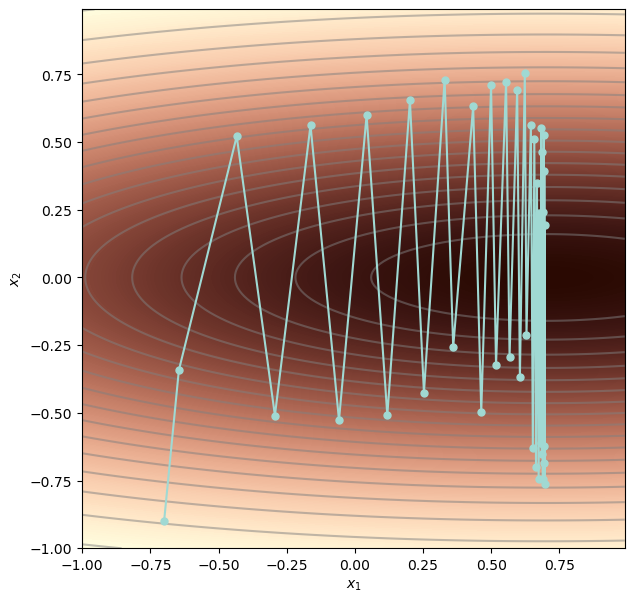

In [2]:
loss_function, x1mesh, x2mesh = get_loss_function_for_plot()

start_posn = np.zeros((2,1))
start_posn[0,0] = -0.7
start_posn[1,0] = -0.9

# Run gradient descent
grad_path1 = grad_descent(start_posn, n_steps=200, alpha=0.08)
draw_function(x1mesh, x2mesh, loss_function, my_colormap, grad_path1)

grad_path2 = grad_descent(start_posn, n_steps=40, alpha=1.0)
draw_function(x1mesh, x2mesh, loss_function, my_colormap, grad_path2)


Because the function changes much faster in x2 than in x1, there is no great step size to choose. If we set the step size so that it makes sensible progress in the x2 direction, then it takes many iterations to converge. If we set the step size so that we make sensible progress in the x1 direction, then the path oscillates in the x2 direction.
This motivates Adam. At the core of Adam is the idea that we should just determine which way is downhill along each axis (i.e., left/right for x1 or up/down for x2) and move a fixed distance in that direction.
The `normalized_gradients` function implements a variant of gradient descent that normalizes the gradients to improve convergence. This method is inspired by the RMSProp optimization algorithm.


**Function Steps**:
1. **Initialization**:
    - `grad_path` is initialized to store the path of the gradient descent.
    - `v` is initialized to store the accumulated squared gradients.

2. **Gradient Descent Loop**:
    - For each step, the gradient `m` is computed using the `get_loss_gradient` function.
    - The squared gradient `v` is updated by accumulating the squared gradients.
    - The position is updated using the normalized gradient

For this we should note that:
- Gradient measurement
- Accumulation of squared gradients:
  $$
  v = v + m^2
  $$
- Update rule:
  $$
  \text{grad\_path}[:, c\_step + 1] = \text{grad\_path}[:, c\_step] - \alpha \frac{m}{\sqrt{v} + \epsilon}
  $$

This method helps in stabilizing the learning process by normalizing the gradients, which can lead to better convergence properties.

In [3]:
def normalized_gradients(start_posn, n_steps, alpha, epsilon=1e-20):
    """
    Run gradient descent with normalized gradients
    start_posn: 2x1 numpy array
    n_steps: int
    alpha: float
    epsilon: float

    Returns: 2x(n_steps+1) numpy array
    """
    grad_path = np.zeros((2, n_steps + 1))
    grad_path[:, 0] = start_posn[:, 0]
    
    v = np.zeros_like(grad_path[:, 0])  # Initialize velocity (as per momentum)

    for c_step in range(n_steps):
        # Measure the gradient
        m = get_loss_gradient(grad_path[0, c_step], grad_path[1, c_step])
        
        # Compute the squared gradient
        v = v + m**2  # Accumulate squared gradients
        
        # Apply the update rule 
        grad_path[:, c_step + 1] = grad_path[:, c_step] - alpha * m / (np.sqrt(v) + epsilon)
    
    return grad_path


Now let's plot with fixed positions

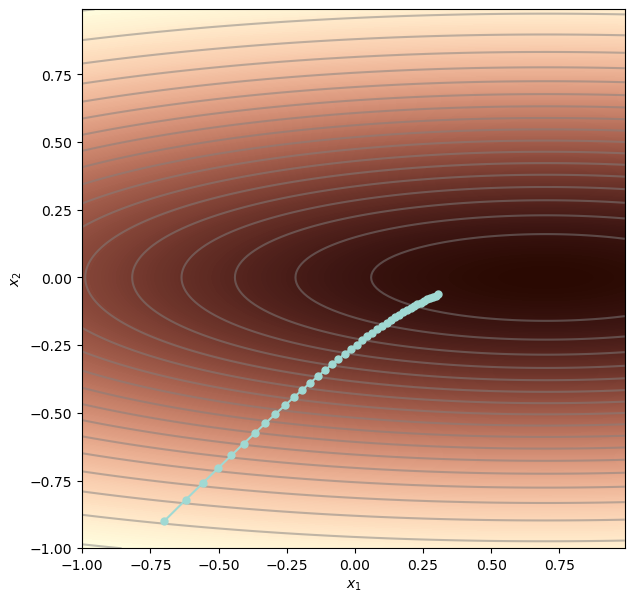

In [4]:
# Let's try out normalized gradients
start_posn = np.zeros((2,1))
start_posn[0,0] = -0.7
start_posn[1,0] = -0.9

# Run gradient descent
grad_path1 = normalized_gradients(start_posn, n_steps=40, alpha=0.08)
draw_function(x1mesh, x2mesh, loss_function, my_colormap, grad_path1)

The `momentum` function implements gradient descent with momentum, which helps accelerate gradients vectors in the right directions, thus leading to faster converging.

**Function Steps**:
1. **Initialization**:
    - `grad_path` is initialized to store the path of the gradient descent.
    - `velocity` is initialized to store the momentum term.

2. **Gradient Descent Loop**:
    - For each step, the gradient `grad` is computed using the `get_loss_gradient` function.
    - The velocity is updated using the momentum equation:
      $$
      \text{velocity} = \beta \cdot \text{velocity} + (1 - \beta) \cdot \text{grad}
      $$
    - The position is updated using the velocity:
      $$
      \text{grad\_path}[:, c\_step + 1] = \text{grad\_path}[:, c\_step] - \alpha \cdot \text{velocity}
      $$

This method helps in smoothing the optimization path and can lead to faster convergence by dampening oscillations.

In [5]:
def momentum(start_posn, n_steps, alpha, beta=0.9):
    """
    Implements gradient descent with momentum based on the equations from the PDF.
    
    Args:
        start_posn: Initial position (numpy array of shape (2, 1)).
        n_steps: Number of steps to run the optimization.
        alpha: Learning rate.
        beta: Momentum coefficient (controls how much of the past gradients are retained).
        
    Returns:
        grad_path: History of positions during optimization.
    """
    grad_path = np.zeros((2, n_steps + 1))
    grad_path[:, 0] = start_posn[:, 0]
    
    velocity = np.zeros_like(grad_path[:, 0])  # Initialize velocity as zero

    for c_step in range(n_steps):
        # Measure the gradient
        grad = get_loss_gradient(grad_path[0, c_step], grad_path[1, c_step])
        
        # Update the velocity using momentum (equation from PDF)
        velocity = beta * velocity + (1 - beta) * grad
        
        # Apply the update rule
        grad_path[:, c_step + 1] = grad_path[:, c_step] - alpha * velocity
    
    return grad_path

Now let's plot and see how Momentum has converged

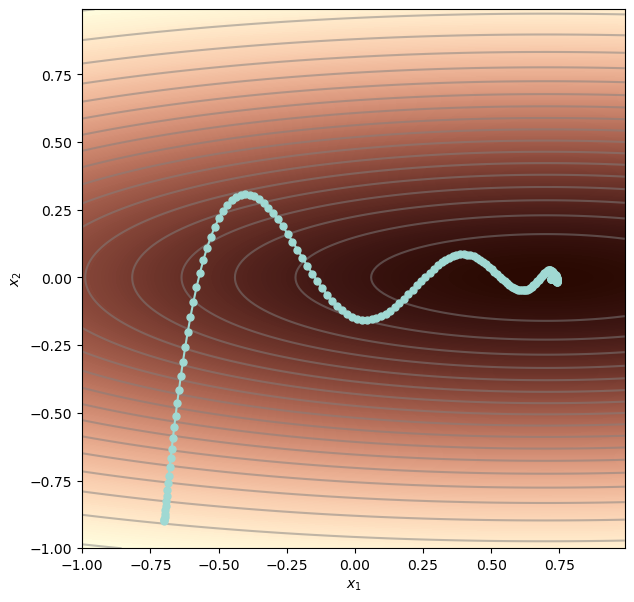

In [6]:
# Plotting function to visualize gradients properly
def plot_gradients_with_momentum():
    """
    Plots the optimization trajectory using momentum-based gradient descent on a contour plot.
    """
    start_posn = np.zeros((2, 1))
    start_posn[0, 0] = -0.7
    start_posn[1, 0] = -0.9
    
    # Run momentum-based gradient descent with higher learning rate and momentum coefficient
    grad_path_momentum = momentum(start_posn, n_steps=200, alpha=0.1, beta=0.95)
    
    # Plot the results
    draw_function(x1mesh, x2mesh, loss_function, my_colormap, grad_path_momentum)

# Now call the function to plot
plot_gradients_with_momentum()


We never actually converge -- the solution just bounces back and forth between the last two points. To make it converge, we add momentum to both the estimates of the gradient and the pointwise squared gradient. We also modify the statistics by a factor that depends on the time to make sure the progress is not slow to start with.


The `adam` function implements the Adam optimization algorithm, which combines the advantages of both the Momentum and RMSProp algorithms. It adapts the learning rate for each parameter by computing individual adaptive learning rates.

**Function Steps**:
1. **Initialization**:
    - `grad_path` is initialized to store the path of the gradient descent.
    - `m` is initialized to store the first moment (mean of gradients).
    - `v_t` is initialized to store the second moment (mean of squared gradients).

2. **Gradient Descent Loop**:
    - For each step, the gradient `grad` is computed using the `get_loss_gradient` function.
    - The first moment `m` is updated using the momentum-based gradient estimate:
      $$
      m_t = \beta_1 \cdot m + (1 - \beta_1) \cdot \text{grad}
      $$
    - The second moment `v_t` is updated using the momentum-based squared gradient estimate:
      $$
      v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot \text{grad}^2
      $$
    - The statistics are modified to correct the bias:
      $$
      \hat{m} = \frac{m}{1 - \beta_1^{t}}
      $$
      $$
      \hat{v_t} = \frac{v_t}{1 - \beta_2^{t}}
      $$
    - The position is updated using the corrected estimates:
      $$
      \theta_{t+1} = \theta_t - \alpha \cdot \frac{\hat{m}}{\sqrt{\hat{v_t}} + \epsilon}
      $$

This method helps in stabilizing the learning process by normalizing the gradients and adapting the learning rate, which can lead to better convergence properties.


In [7]:
def adam(start_posn, n_steps, alpha, beta=0.9, gamma=0.99, epsilon=1e-20):
    grad_path = np.zeros((2, n_steps + 1))
    grad_path[:, 0] = start_posn[:, 0]
    m = np.zeros_like(grad_path[:, 0])  # First moment (mean of gradients)
    v = np.zeros_like(grad_path[:, 0])  # Second moment (mean of squared gradients)

    for c_step in range(n_steps):
        # Measure the gradient
        grad = get_loss_gradient(grad_path[0, c_step], grad_path[1, c_step])

        # Update the momentum-based gradient estimate (equation 6.15 - first line)
        m = beta * m + (1 - beta) * grad

        # Update the momentum-based squared gradient estimate (equation 6.15 - second line)
        v = gamma * v + (1 - gamma) * grad**2

        # Modify the statistics according to equation 6.16
        m_tilde = m / (1 - beta**(c_step + 1))
        v_tilde = v / (1 - gamma**(c_step + 1))

        # Apply the update rule (equation 6.17)
        grad_path[:, c_step + 1] = grad_path[:, c_step] - alpha * m_tilde / (np.sqrt(v_tilde) + epsilon)

    return grad_path

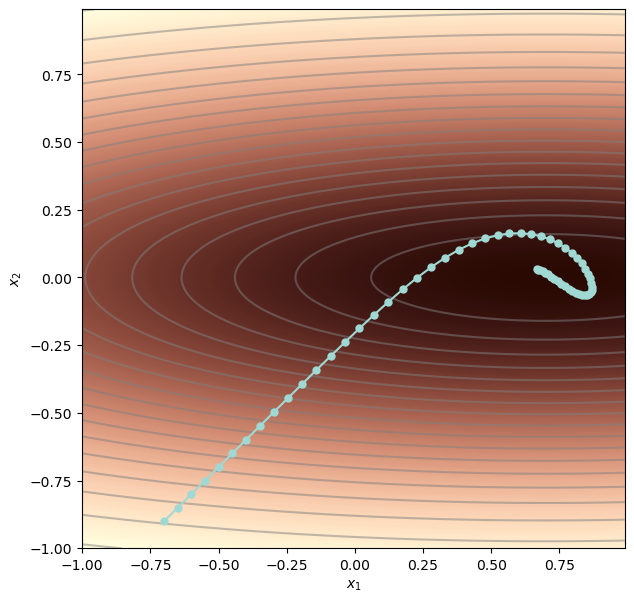

In [8]:
# Let's try out our Adam algorithm
start_posn = np.zeros((2,1))
start_posn[0,0] = -0.7
start_posn[1,0] = -0.9

# Run Adam optimizer
grad_path1 = adam(start_posn, n_steps=60, alpha=0.05)
draw_function(x1mesh, x2mesh, loss_function, my_colormap, grad_path1)
